In [11]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels import RandomEffects
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   GSS_CODE    33 non-null     object  
 2   HECTARES    33 non-null     float64 
 3   NONLD_AREA  33 non-null     float64 
 4   ONS_INNER   33 non-null     object  
 5   SUB_2009    0 non-null      float64 
 6   SUB_2006    0 non-null      float64 
 7   geometry    33 non-null     geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 2.2+ KB
None


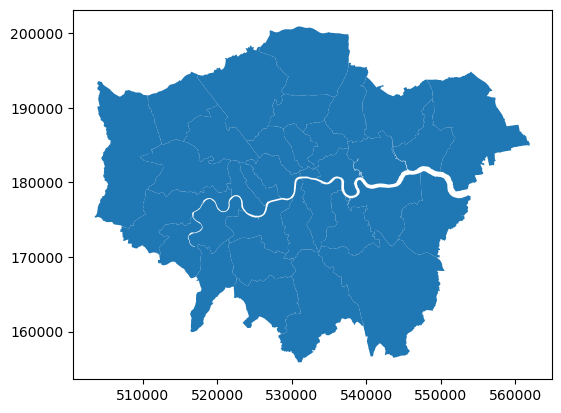

In [12]:
# 加载行政区划图形状文件
gdf = gpd.read_file('data/London_Borough_Excluding_MHW.shp')
gdf.plot()
print(gdf.info())

In [13]:
# 假设你的散点图数据在一个CSV文件中，具有经度和纬度列
df = pd.read_csv('cleaned_data.csv', encoding="ISO-8859-1",parse_dates=['last_review'])
df.head()

gdf_points_filtered = gpd.GeoDataFrame(
    df[['price', 'minimum_nights', 'market_activity','year']],  # 包含所需的列
    geometry=gpd.points_from_xy(df.longitude, df.latitude),  # 使用经度和纬度创建点几何
    crs="EPSG:4326"  # 设置初始坐标参考系统为WGS 84
)
gdf_points_filtered.head()


/tmp/ipykernel_82381/2875706994.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv', encoding="ISO-8859-1",parse_dates=['last_review'])


,price,minimum_nights,market_activity,year,geometry
0,35.0,1,0.806531,2019,POINT (-0.37900 51.44473)
1,103.0,7,0.873340,2019,POINT (-0.21531 51.47398)
2,85.0,3,0.398113,2019,POINT (-0.16670 51.59118)
3,32.0,1,0.453986,2019,POINT (-0.27561 51.37960)
4,30.0,2,0.456846,2019,POINT (-0.39746 51.59863)


In [14]:
# 确定 gdf_points 的初始 CRS，通常是 WGS 84
gdf_points_filtered.crs = "EPSG:4326"

# 尝试再次转换 CRS 到 gdf_neighborhoods 的 CRS
gdf_points_filtered = gdf_points_filtered.to_crs(gdf.crs)

# 检查转换后的 CRS
print(gdf_points_filtered.crs)

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [18]:
# 空间链接
gdf_spatial_join = gpd.sjoin(gdf_points_filtered, gdf, how="inner", op='within')

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


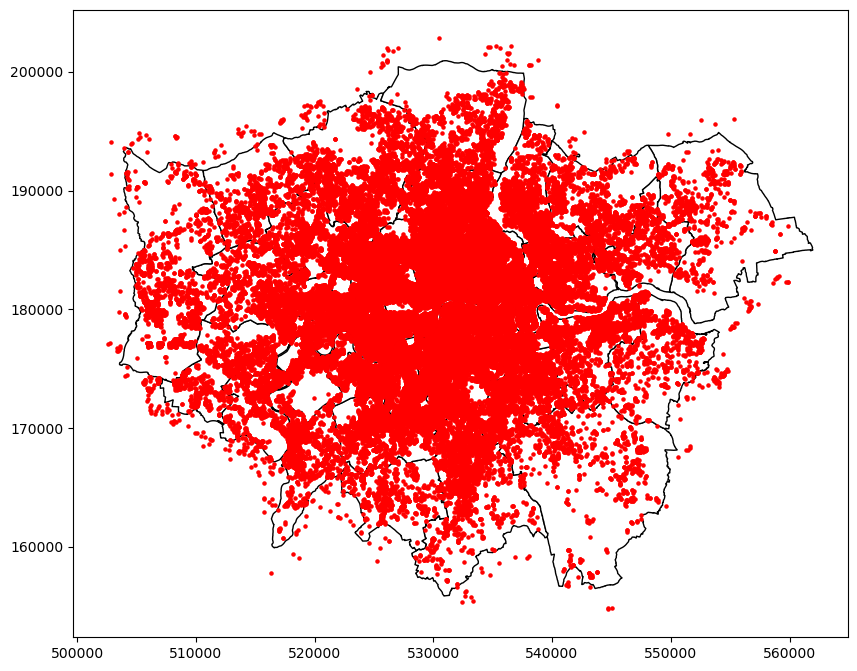

In [19]:
# 创建一个matplotlib图形和子图
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制行政区划图
gdf.plot(ax=ax, color='white', edgecolor='black')

gdf_points_filtered.plot(ax=ax, color='red', markersize=5)
plt.show()
# 显示图形
plt.show()

In [20]:
gdf_points_filtered.head()

,price,minimum_nights,market_activity,year,geometry
0,35.0,1,0.806531,2019,POINT (512750.672 172994.812)
1,103.0,7,0.873340,2019,POINT (524046.538 176511.933)
2,85.0,3,0.398113,2019,POINT (527095.760 189628.487)
3,32.0,1,0.453986,2019,POINT (520105.870 165916.158)
4,30.0,2,0.456846,2019,POINT (511093.063 190081.383)


In [21]:
# 步骤 6: 计算每个 neighborhood 在 2020、2021、2022 年的平均市场活动
# 创建空的 DataFrame 以存储结果
gdf_neighborhoods_activity = pd.DataFrame()
years_of_interest = [2019,2020, 2021, 2022]
for year in years_of_interest:
    # 为每个年份计算平均市场活动
    temp_df = gdf_spatial_join[gdf_spatial_join['year'] == year]
    temp_avg_activity = temp_df.groupby('NAME')['market_activity'].mean().reset_index(name=f'avg_activity_{year}')
    
    # 如果是第一个年份，直接赋值
    if gdf_neighborhoods_activity.empty:
        gdf_neighborhoods_activity = temp_avg_activity
    else:
        # 否则，合并到现有 DataFrame
        gdf_neighborhoods_activity = gdf_neighborhoods_activity.merge(temp_avg_activity, on='NAME', how='outer')


In [22]:
# 步骤 7: 将每年的平均市场活动赋值给 SHP 文件中的相应 neighborhood
gdf_neighborhoods = gdf.merge(gdf_neighborhoods_activity, on='NAME', how='left')
gdf_neighborhoods.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,avg_activity_2019,avg_activity_2020,avg_activity_2021,avg_activity_2022
0,Kingston upon Thames,E09000021,3726.117,0.000,F,NaN,NaN,"POLYGON ((516401.600 160201.800, 516407.300 16...",0.493980,0.559860,0.596666,0.572679
1,Croydon,E09000008,8649.441,0.000,F,NaN,NaN,"POLYGON ((535009.200 159504.700, 535005.500 15...",0.541354,0.592473,0.619650,0.637648
2,Bromley,E09000006,15013.487,0.000,F,NaN,NaN,"POLYGON ((540373.600 157530.400, 540361.200 15...",0.542126,0.598520,0.587918,0.619923
3,Hounslow,E09000018,5658.541,60.755,F,NaN,NaN,"POLYGON ((521975.800 178100.000, 521967.700 17...",0.541073,0.583139,0.609576,0.632794
4,Ealing,E09000009,5554.428,0.000,F,NaN,NaN,"POLYGON ((510253.500 182881.600, 510249.900 18...",0.519774,0.610051,0.626567,0.573441


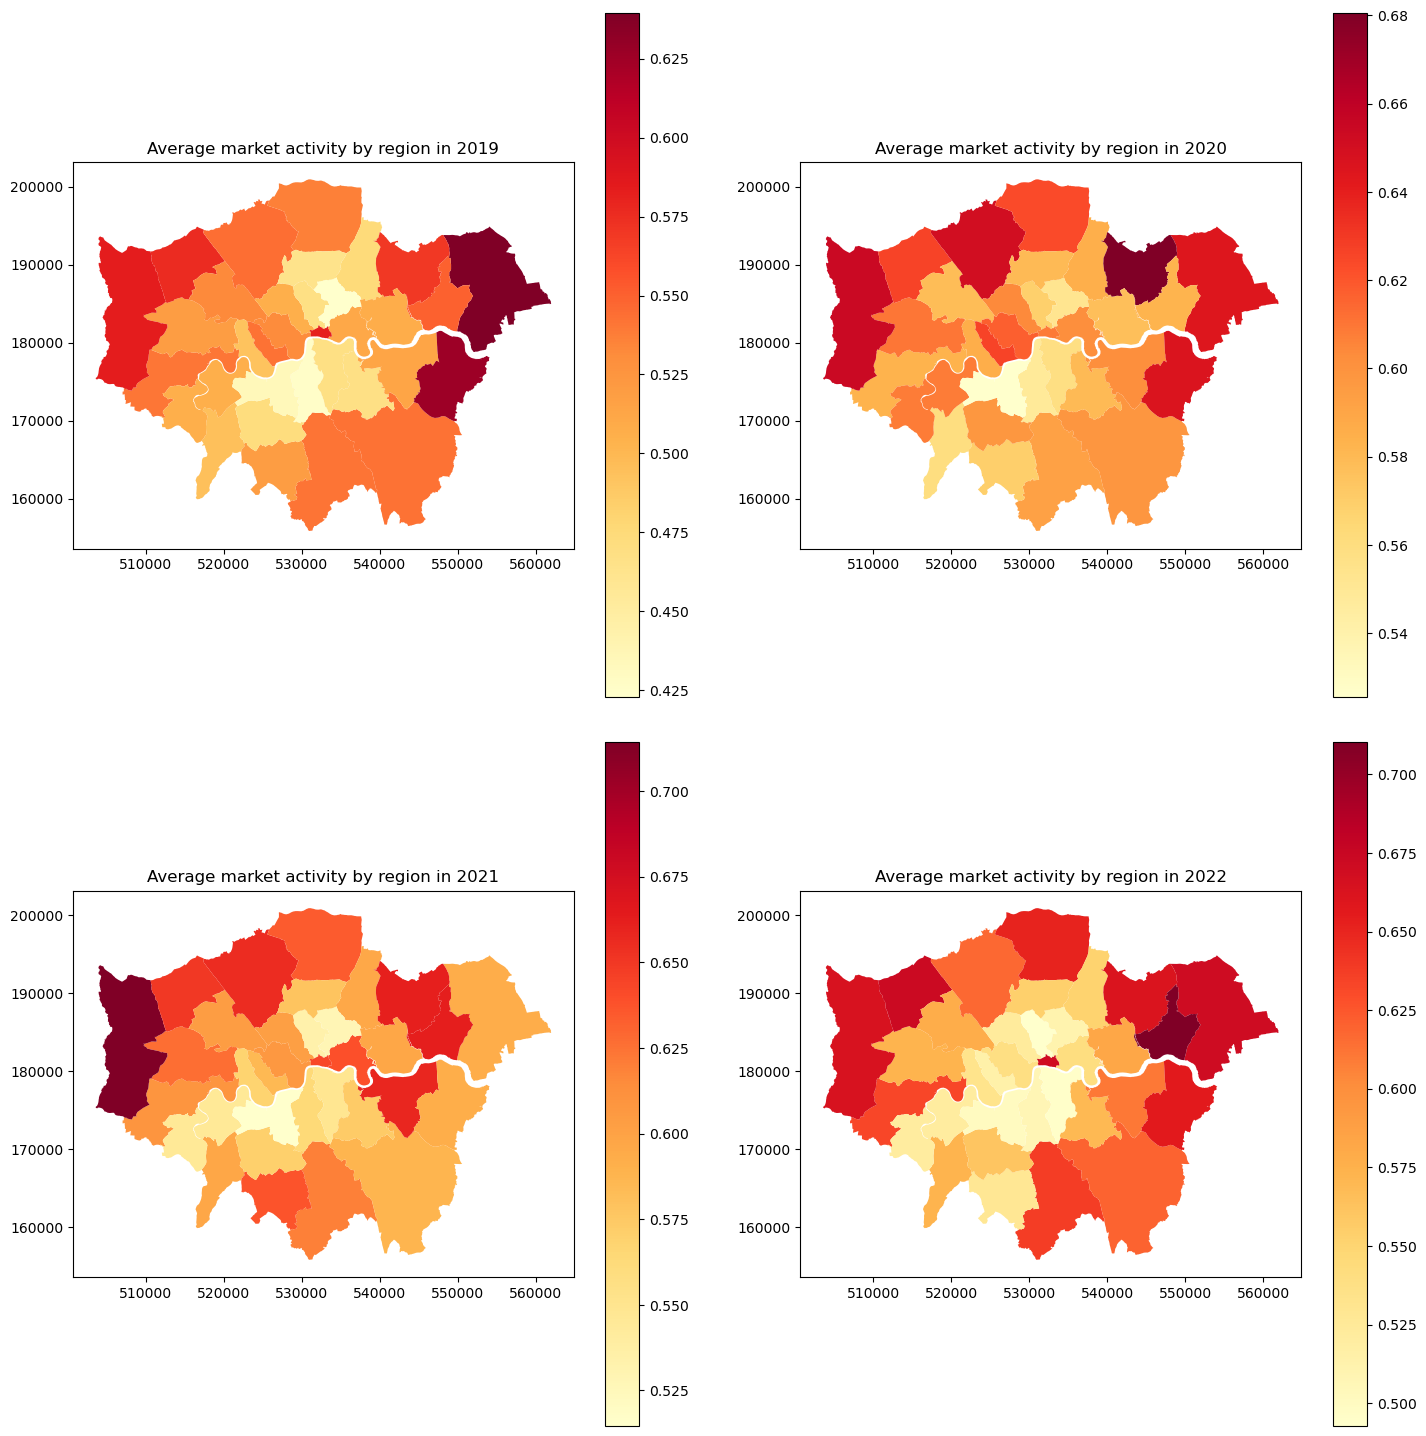

In [36]:
#绘制不同年份每个neighborhood的评价市场活动图
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# 2019年
avg_activity_2019 = gdf_neighborhoods.plot(column='avg_activity_2019', ax=axes[0, 0], legend=True,
                                            cmap='YlOrRd')
axes[0, 0].set_title('Average market activity by region in 2019')

# 2020年
avg_activity_2020 = gdf_neighborhoods.plot(column='avg_activity_2020', ax=axes[0, 1], legend=True,
                                            cmap='YlOrRd')
axes[0, 1].set_title('Average market activity by region in 2020')

# 2021年
avg_activity_2021 = gdf_neighborhoods.plot(column='avg_activity_2021', ax=axes[1, 0], legend=True,
                                            cmap='YlOrRd')
axes[1, 0].set_title('Average market activity by region in 2021')

# 2022年
avg_activity_2022 = gdf_neighborhoods.plot(column='avg_activity_2022', ax=axes[1, 1], legend=True,
                                            cmap='YlOrRd')
axes[1, 1].set_title('Average market activity by region in 2022')

# 调整子图之间的间距
plt.tight_layout(pad=3.0)